In [1]:
import ctypes
import sys
import time
import datetime

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import glob

#path_to_dll = r'F:\SharedData\MCEM Data - Staff Only\Bruker API\Esprit API\Bruker.API.Esprit64.dll'
path_to_dll = r'C:\Users\sergeyg\Github\Bruker Nano APIs\Esprit API\Bruker.API.Esprit64.dll'

# Definitions

In [7]:
# TOpenClientOptions = packed record // structure to describe Quantax start options in ‘OpenClientEx’
# Version: integer; // Version of record structure, should be ‘l’ at the moment
# GUIMode: integer; // ‘0’ = no GUI, ‘1’ = full GUI, ‘2’ = reduced GUI (spectrum chart only)
# StartNew: boolean; // start new instance of Quantax end;
# POpenClientOptions = ^ TOpenClientOptions;
class TOpenClientOptions(ctypes.Structure):
    _pack_ = 1
    _fields_ = [
        ('Version',  ctypes.c_uint32),
        ('GUIMode',  ctypes.c_uint32),
        ('StartNew', ctypes.c_bool),
        ('IdentifierLength', ctypes.c_int8),
        ('TCPHost', ctypes.c_char * 64),
        ('TCPPort', ctypes.c_uint16)
    ]

class TPoint(ctypes.Structure):
    _pack_ = 1
    _fields_ = [
        ('X', ctypes.c_uint32),
        ('Y', ctypes.c_uint32)
    ]
TPointArray = TPoint * 16382
PPointArray = ctypes.POINTER(TPointArray)


# pixelsize = um/pixel
class TRTImageInfoEx(ctypes.Structure):
    _pack_ = 1
    _fields_ = [
        ('Magnification',   ctypes.c_int32),
        ('PixelSizeX',      ctypes.c_double),
        ('PixelSizeY',      ctypes.c_double),
        ('HighVoltage',     ctypes.c_double),
        ('WorkingDistance', ctypes.c_double)
    ]
# typedef TRTImageInfoEx* PRTImageInfoEx;


# Y value of segment
# XStart : x start position on that line
# XCount : number of contiguous pixels
# in Delphi TRTSegment = packed record
class TSegment(ctypes.Structure):
    _pack_ = 1
    _fields_ = [
        ('Y'     , ctypes.c_uint32),
        ('XStart', ctypes.c_uint32),
        ('XCount', ctypes.c_uint32)
    ]


class TLineSegment(ctypes.Structure):
    # TLineSegment     = packed record
    #    Y,XStart,XEnd : word;
    #  end;
    # TLineSegmentArray = array[0..8191] of TLineSegment;
    _pack_ = 1
    _fields_ = [
        ('Y', ctypes.c_ushort),
        ('XStart', ctypes.c_ushort),
        ('XEnd', ctypes.c_ushort)
    ]    
    
# struct TRTSpectrumHeaderRec {
# unsigned __int8 IdentifierLength;
# char Identifier[25];// 'Rontec XRay spectrum'
# int32_t Version;// Version information
# int32_t Size;// Size in byte
# double DateTime;// Delphi 5.0 version of date and time
# int32_t ChannelCount;//
# int32_t ChannelOffset;// First channel index
# double CalibrationAbs;// Energy of first channel
# double CalibrationLin;          // keV per channel
# double SigmaAbs;// Sigma^2 energy calibration
# double SigmaLin;
# // additional data compared to normal Roentec header
# int32_t RealTime;// real measure time in ms
# int32_t LifeTime;// life time in ms
# };
# #pragma pack(pop)


class TRTSpectrumHeaderRec(ctypes.Structure):
    _pack_ = 1
    _fields_ = [
        ('Identifier', ctypes.c_char_p*25),
        ('Version', ctypes.c_uint32),
        ('Size', ctypes.c_uint32),
        ('DateTime', ctypes.c_double),
        ('ChannelCount', ctypes.c_uint32),
        ('ChannelOffset', ctypes.c_uint32),
        ('CalibrationAbs', ctypes.c_double),
        ('CalibrationLin', ctypes.c_double),
        ('SigmaAbs', ctypes.c_double),
        ('SigmaLin', ctypes.c_double),
        ('RealTime', ctypes.c_uint32),
        ('LifeTime', ctypes.c_uint32)
    ]

    

def print_spectrum_header(spectrum_header : TRTSpectrumHeaderRec):
    print(f'Version: {spectrum_header.Version}')
    print(f'Size   :  {spectrum_header.Size}')
    print(f'ChannelCount   :  {spectrum_header.ChannelCount}')
    print(f'RealTime       :  {spectrum_header.RealTime}')

    



    

errors = {-1 : 'IFC_ERROR_IN_EXECUTION',
         -2 : 'IFC_ERROR_WRONG_PARAMETER (execution)',
         -3 : 'IFC_ERROR_SPECTRUM_BUFFER_EMPTY',
         -4 : 'IFC_ERROR_PARAMETER_MISSED',
         -5 : 'IFC_ERROR_TOO_MANY_PARAMETERS',
         -6 : 'IFC_ERROR_USER_TERMINATED',
         -7 : 'IFC_ERROR_TIMEOUT',
         -8 : 'IFC_ERROR_UNKNOWN_VALUE_NAME',
         -9 : 'IFC_ERROR_WRONG_VALUE_TYPE',
         -10 : 'IFC_ERROR_NO_LICENCE',
         -11 : 'IFC_ERROR_RESULT_BUFFER_INSUFFICIENT',
         -12 : 'IFC_ERROR_HARDWARE_LOCKED',
         -51: 'IFS_ERROR_PARAMETER_MISSED',
         -52 : 'IFS_ERROR_FUNCTION_NOT_IMPLEMENTED',
         -21 : 'CONN_ERROR_UNKNOWN',
         -22 : 'CONN_ERROR_INTERFACE_NOT_CONNECTED',
         -23 : 'CONN_ERROR_PARAMETER_MISSED',
         -24 : 'CONN_ERROR_ANSWER_TIMEOUT',
         -25 : 'CONN_ERROR_SERVER_NOT_RESPONDING',
         -26 : 'CONN_ERROR_RESULT_MISSED',
         -27 : 'CONN_ERROR_NO_INTERFACE',
         -28 : 'CONN_ERROR_INVALID_LOGIN',
         -29 : 'CONN_ERROR_NO_CONNECTION_TO_SERVER',
         -30 : 'CONN_ERROR_SERVER',
         -31 : 'CONN_ERROR_ACTION_ABORTED',
         -101 : 'ERROR_WRONG_PARAMETER',
         -102 : 'ERROR_FILE_NOT_EXIST',
         -103 : 'ERROR_INVALID_CONNECTION',
         -104 : 'ERROR_NO_ANSWER',
         -105 : 'ERROR_CAN_NOT_START_PROCESS',
         -106 : 'ERROR_INVALID_RESULT_DATA',
         -107 : 'ERROR_SETTINGS_NOT_FOUND',
         -108 : 'ERROR_INVALID_SERVER_CONNECTION',
         -109 : 'ERROR_IN_EXECUTION',
         -110 : 'ERROR_IFC_BUSY',
         -201 : 'STATE_WAS_RUNNING_BEFORE'
}

# Initialise the connection to Bruker Esprit API

In [3]:
pServer = ''.encode('utf-8') # Pointer to a server name (if empty the local/default server is referenced)

User = 'edx'
pUser = User.encode('utf-8')

password = 'edx'
pPassword = password.encode('utf-8')

host = '127.0.0.1' # 'local host'
pHost = host.encode('utf-8')

port = ctypes.c_uint16(0)

Options = TOpenClientOptions()
Options.Version = 1
Options.GUIMode = 1 # GUIMode: integer; // ‘0’ = no GUI, ‘1’ = full GUI, ‘2’ = reduced GUI (spectrum chart only)
Options.StartNew = False # If true, function starts always a new client instance
Options.IdentifierLength = 8 # ???
Options.TCPHost = host.encode('utf-8')
Options.TCPport = port
Options_ptr = ctypes.pointer(Options)


CID = ctypes.c_uint32(123456)  # Identification code for an actual server/client instance
CID_ptr = ctypes.pointer(CID)  # Pointer to Identification code for an actual server/client instance

StartNew = ctypes.c_bool(False)
GUI      = ctypes.c_bool(True) 

try:
    esprit = ctypes.cdll.LoadLibrary(path_to_dll)
    print(path_to_dll, esprit)
except:
    error_message = f'path to dll {path_to_dll} does not exist'
    print(error_message + '\n')

C:\Users\sergeyg\Github\Bruker Nano APIs\Esprit API\Bruker.API.Esprit64.dll <CDLL 'C:\Users\sergeyg\Github\Bruker Nano APIs\Esprit API\Bruker.API.Esprit64.dll', handle 400000 at 0x20173042260>


In [6]:
type(esprit)

ctypes.CDLL

# Connect to the Esprit API server

In [6]:
### Connect to ESprit

output = esprit.OpenClient(pServer, pUser, pPassword, StartNew, GUI, CID_ptr)

print(f'Identification code for an actual server/client instance {CID.value}')

print(f'Error output = {errors[output]}')

Identification code for an actual server/client instance 123456
Error output = ERROR_FILE_NOT_EXIST


# Verify the connection, test a simple quiry

In [7]:
buffer_size = ctypes.c_int32(999)
query = ' ' * 1000 # block of memory for 1000 characters
query = query.encode('utf-8') # bytes, reference, char*

output = \
    esprit.QueryInfo(CID, query, buffer_size)

if output==0:
    print('SEM servers/client: ', str(query), '\n')
    error_message = ''
else:
    error_message = f'No SEM servers/clients info could be fetched, ERROR code is {output}, {errors[output]}'
    print( error_message + '\n')

No SEM servers/clients info could be fetched, ERROR code is -103, ERROR_INVALID_CONNECTION



# Quiery the SEM state, test communication with the API

In [8]:
mag = ctypes.c_double(0) # magnification
high_voltage  = ctypes.c_double(0) # high voltage in keV
working_distance  = ctypes.c_double(0) # working ditance in mm
mag_ptr = ctypes.pointer(mag)
high_voltage_ptr = ctypes.pointer(high_voltage)
working_distance_ptr = ctypes.pointer(working_distance)

output = \
    esprit.GetSEMData(CID, mag_ptr, high_voltage_ptr, working_distance_ptr)

print(f'mag = {mag.value}, HV = {high_voltage.value}, WD = {working_distance.value}')
if output==0:
    error_message = ''
    print('SEM data retrieved successfully\n')
else:
    error_message = f'No SEM data could be fetched, ERROR code is {output}, {errors[output]}'
    print( error_message + '\n')

mag = 0.0, HV = 0.0, WD = 0.0
No SEM data could be fetched, ERROR code is -103, ERROR_INVALID_CONNECTION



# Retrieve the image settings

In [9]:
# int32_t ImageGetConfiguration(uint32_t CID, uint32_t & Width, uint32_t & Height, uint32_t & Average, bool & Ch1, bool & Ch2)
# ImageGetConfiguration(FCID,w,h,Average,Ch1,Ch2);
# w,h, Average      : Cardinal;
# Width: Image  width in pixel
# Height: Image height in pixel
# Average: Number of pixel average cycles. Depending on the number of active channels one cycle takes
# 1 us (for one active channel) or 2 us (for two active channels)
# Ch1, Ch2: Image channel active or not

width   = ctypes.c_uint32(0) # image width
height  = ctypes.c_uint32(0) # image height
average = ctypes.c_uint32(1)
Ch1     = ctypes.c_bool(False)
Ch2     = ctypes.c_bool(False)
################## pointers ##################
width_ptr   = ctypes.pointer(width)
height_ptr  = ctypes.pointer(height)
average_ptr = ctypes.pointer(average)
Ch1_ptr     = ctypes.pointer(Ch1)
Ch2_ptr     = ctypes.pointer(Ch2)


output = \
    esprit.ImageGetConfiguration(CID,
                                 width_ptr, height_ptr,
                                 average_ptr, Ch1_ptr, Ch2_ptr)

if output==0:
    error_message = ''
    print(f'Image configuration: width {width.value}; height {height.value}; '
          f'average {average.value}); Ch1 {Ch1.value};  Ch2: {Ch2.value}\n')
else:
    error_message = f'No image configuration could be retrieved, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')
    

No image configuration could be retrieved, ERROR code is -103, ERROR_INVALID_CONNECTION



# Get SEM image

image info: mag=0, pixelsize=0.0, HV=0.0, WD=0.0
Could not acquire image, ERROR code is -104, ERROR_NO_ANSWER



C:\Users\sergeyg\AppData\Local\Temp\ipykernel_4872\535876696.py:57: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image, cmap='gray')
C:\Users\sergeyg\AppData\Local\Temp\ipykernel_4872\535876696.py:57: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image, cmap='gray')


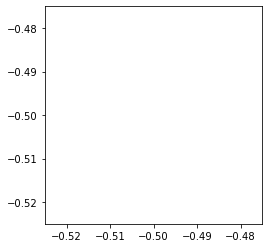

In [10]:
# int32_t ImageAquireImage(uint32_t CID, int32_t Ch, bool ShowProgress, void* Buffer, int32_t& BufSize, PRTImageInfoEx ImgInfo)
# ImageAquireImageEx(FCID, 2, MemStream.Memory, 0, aSize, @ImgInfo)
#
image_info = TRTImageInfoEx()
image_info_ptr = ctypes.pointer(image_info)

extra_buffer_for_image = 200000
buffer_size = ctypes.c_uint32(width.value * height.value + extra_buffer_for_image) # MemStream.SetSize(W*H+20000); aSize:=MemStream.Size;
buffer_size_ptr = ctypes.pointer(buffer_size)

show_progress=False
channel = 1
channel = ctypes.c_uint32(channel)
show_progress = ctypes.c_bool(show_progress)

# version 1 - void pointer
#self.image_buffer_ptr = ctypes.c_void_p() # void* Buffer

# version 2 : array
# the image has 8 bit depth (0..255) hence ctypes.c_uint8
IntArray = ctypes.c_uint8 * buffer_size.value # int8 array the size of width*height+extra for storing the image
image_buffer = IntArray() # initialise the array
image_buffer_ptr = ctypes.pointer(image_buffer) # pointer to the image buffer array



output = \
    esprit.ImageAquireImage(CID,
                             channel, show_progress,
                             image_buffer_ptr, buffer_size_ptr, image_info_ptr)

print(f'image info: mag={image_info.Magnification}, pixelsize={image_info.PixelSizeX}, '
      f'HV={image_info.HighVoltage}, WD={image_info.WorkingDistance}')

if output==0:
    error_message = ''
    print(f'image acquired successfully\n')
else:
    error_message = f'Could not acquire image, ERROR code is {output}, {errors[output]}'
    print( error_message + '\n')

    
    
    
image = np.zeros( buffer_size.value )
for ii in range( buffer_size.value ):
    image[ii] = image_buffer_ptr.contents[ii] # populate the 1D array from the buffer pointer
    
    

# remove the zeros in the extra buffer for image
image = image[ : -extra_buffer_for_image]


image = np.reshape(image, (height.value, width.value) ) # reshape the 1D array into the image shape
plt.figure(11)
plt.imshow(image, cmap='gray')
plt.show()


# Test - set beam to point X,Y

In [11]:
# int32_t ImageSetPoint(uint32_t CID, uint32_t X, uint32_t Y)
# Pixel X Y value of the current image to set the electron beam to


x_pos = 100
y_pos = 200


X = ctypes.c_uint32(x_pos)
Y = ctypes.c_uint32(y_pos)

output = \
    esprit.ImageSetPoint(CID, X, Y)

if output==0:
    error_message = ''
    print(f'Beam position set to ({X.value}, {Y.value})\n')
else:
    error_message = f'Could not position the beam to ({X.value}, {Y.value}), ERROR code is {output}, {errors[output]}'
    print( error_message + '\n')

Could not position the beam to (100, 200), ERROR code is -103, ERROR_INVALID_CONNECTION



# Test - Line scans with HIGH dwell time; Points measurements

In [67]:
# int32_t StartPointListMeasurement(uint32_t CID, int32_t SPU, uint32_t SegmentCount, PSegmentList LineSegments, uint32_t RealTime);
# CID: Identification code for an actual server/ client instance
# SPU: Spectrometer index (1…n)
# SegmentCount: Description of points to measure
# RealTime: Acquisition time in ms


dwell_time = 10 # ms
x = 100
y = 200

#################################################################################

dwell_time = ctypes.c_uint32(dwell_time)

SPU = ctypes.c_uint32(1) # spectrometer channel, 1 is used here

segment = TSegment()
segment.Y      = ctypes.c_uint32(y) # y start
segment.XStart = ctypes.c_uint32(x) # x start
# TODO - try different line length other than 1
segment.XCount = ctypes.c_uint32(1) # single pixel line


segment_count = 1
TSegmentList = TSegment * segment_count # array/list of segment with a single element
list_of_segments = TSegmentList(segment) # populate the array with a segment
list_of_segments_ptr = ctypes.pointer(list_of_segments) # pointer to the list of segments/list with a single segment


output = \
    esprit.StartPointListMeasurement(CID, SPU, ctypes.c_uint32(segment_count),
                                      list_of_segments_ptr, dwell_time)

if output==0:
    error_message = ''
    print(f'Segment starting at ({x},{y}) exposed during dwell of {dwell_time.value} ms\n')
else:
    error_message = f'Could not expose segment at ({x},{y}) for dwell of {dwell_time.value} ms\n, ERROR code is {output}, {errors[output]}'
    print( error_message + '\n')

Could not expose segment at (100,200) for dwell of 10 ms
, ERROR code is -103, ERROR_INVALID_CONNECTION



In [68]:
print(list_of_segments[0].XStart, list_of_segments[0].Y, list_of_segments[0].XCount)


100 200 1


# Get the line scan data

In [69]:
spectrum_index = ctypes.c_uint32(1)

# # allocate 64000 memory for the header
# TRTSpectrumHeaderRecArray = TRTSpectrumHeaderRec * 64000
# SpectrumBuf_ptr = ctypes.POINTER(TRTSpectrumHeaderRecArray)

SpectrumBuf = TRTSpectrumHeaderRec()
SpectrumBuf_ptr = ctypes.pointer(SpectrumBuf)


output = \
    esprit.GetPointListSpectrum(CID, spectrum_index,
                                 SpectrumBuf_ptr, ctypes.c_uint32(64000))

if output==0:
    error_message = ''
    print(f'Retrieving the line scan specturum\n')
else:
    error_message = f'Could not retrieve the line scan data, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

Could not retrieve the line scan data, ERROR code is -106, ERROR_INVALID_RESULT_DATA



# X-ray spectrum measurement

In [ ]:
# int32_t StartSpectrumMeasurement(uint32_t CID, int32_t Device, uint32_t RealTime)
# *****
# // Device: Number of spectrometer ( 1 in most cases )
# // RealTime: Measure time in ms ( 0 means endless measurement )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# StartSpectrumMeasurement(FCID,1,0);
# StartSpectrumMeasurement(FCID,1,TimeSpinEdit.Value);


# int32_t StopSpectrumMeasurement(uint32_t CID, int32_t Device)
# *****
# // Device: Number of spectrometer ( 1 in most cases )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# StopSpectrumMeasurement(FCID,1);





# int32_t ReadSpectrum(uint32_t CID, int32_t Device)
# *****
# // Read current spectrum from spectrometer to buffer
# // Device: Number of spectrometer ( 1 in most cases )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# if (ReadSpectrum(FCID,1)=0)...


# int32_t GetSpectrum(uint32_t CID, int32_t Buffer, PRTSpectrumHeaderRec pSpectrumBuf, int32_t BufSize)
# // Buffer: Buffer index ( 0 for loaded spectrum buffer, > 0 for spectrometer buffers )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# ********
# (GetSpectrum(FCID,1,SpectrumBuf,64000)=0)
# SpectrumBuf : PRTAPISpectrumHeaderRec;
# PRTSpectrumHeaderRec -> PRTAPISpectrumHeaderRec


# int32_t GetSpectrometerConfiguration(uint32_t CID, int32_t SPU, uint32_t& MaxEnergy, uint32_t& PulseThroughput)
# *****
# SPU: Number of spectrometer ("1" in most cases)
# MaxEnergy: Energy in keV of that last spectrum channel
# PulseTroughput: Maximum pulse output rate of the selected amplifier in cps (counts per second)


# int32_t GetSpectrometerParams(uint32_t CID, int32_t SPU, void* Buffer, int32_t& BufSize)
# *****
# FSpectrometerParams : PAnsiChar;
# BufCount:=32000;
# ReAllocMem(FSpectrometerParams,BufCount);
# GetSpectrometerParams(FCID,1,FSpectrometerParams,BufCount);
# ReAllocMem(FSpectrometerParams,BufCount);
# StartSpectrumMeasurement(FCID,1,0);


# int32_t CreateSpectrum(char* SpectrometerParams, PRTSpectrumHeaderRec SpectrumData, char* ResultData, int32_t& ResultSize)
# // Create a complete Bruker spectrum from
# Bruker.API.CommonFunctions_imp.CreateSpectrum(Params,SpectrumBuf,FullSpectrum,FullSize)=0


# int32_t PutSpectrum(uint32_t CID, void* Spectrum, int32_t BufSize)
# *****
# // Send spectrum back to 'loaded' buffer
# // Spectrum : Bruker spectrum buffer
# // BufferSiz: size of spectrum buffer
# // Result   : Function call sucessful or not ( 0 = success, otherwise error )
# // Remarks  : if one wants to use that function one has to build a complete Bruker spectrum with
# //                functions 'GetSpectrum', 'GetSpectrometerParams' and 'CreateSpectrum'

        

SpectrumBuf : PRTAPISpectrumHeaderRec;
PB          : PByte;
PL          : PLongInt;
i           : integer;
Params      : PAnsiChar;
ParSize     : integer;
FullSpectrum: PAnsiChar;
FullSize    : integer;

SpectrumBuf:=AllocMem(64000);
 // Load spectrum (it is in buffer '0') afterwards and read its data into this demo
 if (GetSpectrum(FCID,0,SpectrumBuf,64000)=0) then
 

// Remember spectrum buffer for next actions
FCurrentBuffer:=0;

// Read spectrometer params
ParSize:=20000;
Params:=AllocMem(ParSize);
if GetSpectrometerParams(FCID,FCurrentBuffer,Params,ParSize)=0 then

FullSize:=50000;
FullSpectrum:=AllocMem(FullSize);
// Create full spectrum and send to 'load' buffer (='0')
if Bruker.API.CommonFunctions_imp.CreateSpectrum(Params,SpectrumBuf,FullSpectrum,FullSize)=0
  then PutSpectrum(FCID,FullSpectrum,FullSize);

# 1. Start Spectrum Measurement, wait, then Stop

In [14]:
# int32_t StartSpectrumMeasurement(uint32_t CID, int32_t Device, uint32_t RealTime)
# *****
# // Device: Number of spectrometer ( 1 in most cases )
# // RealTime: Measure time in ms ( 0 means endless measurement )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# StartSpectrumMeasurement(FCID,1,0);
# StartSpectrumMeasurement(FCID,1,TimeSpinEdit.Value);

real_time = 100 
device    = ctypes.c_int32(1) # Device: Number of spectrometer ( 1 in most cases )
real_time = ctypes.c_uint32() # #RealTime: Measure time in ms ( 0 means endless measurement )

output = \
    esprit.StartSpectrumMeasurement(CID, device, real_time)

if output==0:
    error_message = ''
    print(f'Started spectrum measurement\n')
else:
    error_message = f'Could not start the spectrum measurement, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

Could not start the spectrum measurement, ERROR code is -103, ERROR_INVALID_CONNECTION



In [17]:
"""
    sleep for the time of measumement
"""

time.sleep(real_time.value)

In [16]:
# int32_t StopSpectrumMeasurement(uint32_t CID, int32_t Device)
# *****
# // Device: Number of spectrometer ( 1 in most cases )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# StopSpectrumMeasurement(FCID,1);

output = \
    esprit.StopSpectrumMeasurement(CID, device)

if output==0:
    error_message = ''
    print(f'Stopping spectrum measurement\n')
else:
    error_message = f'Could not stop the spectrum measurement, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

Could not stop the spectrum measurement, ERROR code is -103, ERROR_INVALID_CONNECTION



# 2. Get Spectrometer Configuration

In [40]:
# int32_t GetSpectrometerConfiguration(uint32_t CID, int32_t SPU, uint32_t& MaxEnergy, uint32_t& PulseThroughput)
# *****
# SPU: Number of spectrometer ("1" in most cases)
# MaxEnergy: Energy in keV of that last spectrum channel
# PulseTroughput: Maximum pulse output rate of the selected amplifier in cps (counts per second)


SPU = ctypes.c_int32(1)         # Number of spectrometer ("1" in most cases)
max_energy = ctypes.c_uint32(0) # Energy in keV of that last spectrum channel
max_energy_ptr = ctypes.pointer(max_energy)
pulse_throughput = ctypes.c_uint32(0) # Maximum pulse output rate of the selected amplifier in cps (counts per second)
pulse_throughput_ptr = ctypes.pointer(pulse_throughput)

output = \
    esprit.GetSpectrometerConfiguration(CID, SPU, max_energy_ptr, pulse_throughput_ptr)

if output==0:
    error_message = ''
    print(f'Successfully received spectrometer parameters:\n')
else:
    error_message = f'Could not stop the spectrum measurement, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')
    
    
print(f'Spectrometer: max energy = {max_energy.value}')
print(f'Spectrometer: pulse_throughput = {pulse_throughput.value}, counts per seconsd')


Could not stop the spectrum measurement, ERROR code is -103, ERROR_INVALID_CONNECTION

Spectrometer: max energy = 0
Spectrometer: pulse_throughput = 0, counts per seconsd


# 3. Read spectrum from the spectrometer to buffer

In [26]:
# int32_t ReadSpectrum(uint32_t CID, int32_t Device)
# *****
# // Read current spectrum from spectrometer to buffer
# // Device: Number of spectrometer ( 1 in most cases )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# if (ReadSpectrum(FCID,1)=0)...

device = ctypes.c_int32(1) # Device: Number of spectrometer ( 1 in most cases )

output = \
    esprit.ReadSpectrum(CID, device)

if output==0:
    error_message = ''
    print(f'Spectrum read into the buffer successfully\n')
else:
    error_message = f'Could not read the spectrum into the buffer, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

Could not read the spectrum into the buffer, ERROR code is -103, ERROR_INVALID_CONNECTION



# 4. Get the spectrum

In [68]:
# int32_t GetSpectrum(uint32_t CID, int32_t Buffer, PRTSpectrumHeaderRec pSpectrumBuf, int32_t BufSize)
# // Buffer: Buffer index ( 0 for loaded spectrum buffer, > 0 for spectrometer buffers )
# // Result: Function call sucessful or not ( 0 = success, otherwise error )
# ********
# (GetSpectrum(FCID,1,SpectrumBuf,64000)=0)
# SpectrumBuf : PRTAPISpectrumHeaderRec;
# PRTSpectrumHeaderRec -> PRTAPISpectrumHeaderRec

buffer_size = 64000
buffer_size = ctypes.c_int32(buffer_size)
 
buffer = ctypes.c_int32(1) # Buffer index ( 0 for loaded spectrum buffer, > 0 for spectrometer buffers )

spectrum_buffer = TRTSpectrumHeaderRec()
spectrum_buffer_ptr = ctypes.pointer(spectrum_buffer)
# TRTSpectrumHeaderRecArray = TRTSpectrumHeaderRec * 64000
# spectrum_buffer_ptr = ctypes.POINTER(TRTSpectrumHeaderRecArray)

output = \
    esprit.GetSpectrum(CID, device, buffer, spectrum_buffer_ptr, buffer_size)

if output==0:
    error_message = ''
    print(f'GetSpectrum is successfull\n')
    print_spectrum_header(spectrum_buffer)
else:
    error_message = f'Could not GetSpectrum, ERROR code is {output}' #', {errors[output]}'
    print(error_message + '\n')

    
print_spectrum_header(spectrum_buffer)
    

Could not GetSpectrum, ERROR code is 232

Version: 0
Size   :  0
ChannelCount   :  0
RealTime       :  0


# 5. Save spectrum to file

In [50]:
# int32_t SaveSpectrum(uint32_t CID, int32_t Buffer, char* pFileName)
# // Save spectrum buffer to file
# function SaveSpectrum(CID:LongWord;Buffer:longint;pFileName:PAnsiChar):longint;stdcall;external csAPILibFile;
#    // pFilename   : Complete filename for spectrum ( normally with *.spx extension )
#    // Result      : Function call sucessful or not ( 0 = success, otherwise error )


buffer = ctypes.c_int32(1) # Buffer index ( 0 for loaded spectrum buffer, > 0 for spectrometer buffers), 0 - reserved for Load

ts = time.time()
stamp = datetime.datetime.fromtimestamp(ts).strftime('%y%m%d.%H%M%S')  # make a timestamp for new file
file_name = "spectrum_" + stamp + '.txt'
print(file_name)
file_name = file_name.encode('utf-8') # bytes, reference, char*, PAnsiChar equivalent


output = \
    esprit.SaveSpectrum(CID, buffer, file_name)

if output==0:
    error_message = ''
    print(f'Spectrum saved successfully to file {file_name}\n')
else:
    error_message = f'Could not save spectrum, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

spectrum_230503.131109.txt
Could not save spectrum, ERROR code is -103, ERROR_INVALID_CONNECTION



# 6. Get spectrometer params (necessary for PutSpectrum)

In [59]:
# int32_t GetSpectrometerParams(uint32_t CID, int32_t SPU, void* Buffer, int32_t& BufSize)
# // Reads full parameter block of current spectrometer params (needed to create full Bruker spectrum)
# *****
# FSpectrometerParams : PAnsiChar;
# BufCount:=32000;
# ReAllocMem(FSpectrometerParams,BufCount);
# GetSpectrometerParams(FCID,1,FSpectrometerParams,BufCount);
# *****************
# Params  : PAnsiChar;
# ParSize:=20000;
# Params:=AllocMem(ParSize);
# if GetSpectrometerParams(FCID,FCurrentBuffer,Params,ParSize)=0 then

buffer_size = 32000
spectrometer_params = ' ' * buffer_size # memory reserved
spectrometer_params = spectrometer_params.encode('utf-8') # bytes, reference, char*, PAnsiChar equivalent

print(spectrometer_params[0:10])

buffer_size = ctypes.c_int32(buffer_size)
buffer_size_ptr = ctypes.pointer(buffer_size)

SPU = ctypes.c_int32(1)  # Number of spectrometer ("1" in most cases)


output = \
    esprit.GetSpectrometerParams(CID, SPU, spectrometer_params, buffer_size_ptr)

if output==0:
    error_message = ''
    print(f'GetSpectrometerParams was acquired successfully\n')
else:
    error_message = f'Could not perform GetSpectrometerParams, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')
    
    
print(spectrometer_params[0:10])


b'          '
Could not perform GetSpectrometerParams, ERROR code is -106, ERROR_INVALID_RESULT_DATA

b'          '


# 7. Create Spectrum

In [65]:
# int32_t CreateSpectrum(char* SpectrometerParams, PRTSpectrumHeaderRec SpectrumData, char* ResultData, int32_t& ResultSize)
# // Create a complete Bruker spectrum from
# Bruker.API.CommonFunctions_imp.CreateSpectrum(Params,SpectrumBuf,FullSpectrum,FullSize)=0
# **************************
# Params      : PAnsiChar;
# SpectrumBuf : PRTAPISpectrumHeaderRec;
# FullSpectrum: PAnsiChar;
# FullSize:=50000;
# FullSpectrum:=AllocMem(FullSize);    
# ParSize:=20000;
# Params:=AllocMem(ParSize);    
# SpectrumBuf:=AllocMem(64000);
# FullSpectrum,FullSize ->    ResultData,  ResultSize

result_size = 50000
result_size = ctypes.c_int32(result_size)
result_size_ptr = ctypes.pointer(result_size)

result_data = ' ' * result_size.value # memory reserved
result_data = result_data.encode('utf-8') # bytes, reference, char*, PAnsiChar equivalent

spectrum_data = TRTSpectrumHeaderRec()
spectrum_data_ptr = ctypes.pointer(spectrum_data)
# TRTSpectrumHeaderRecArray = TRTSpectrumHeaderRec * 64000
# spectrum_data_ptr = ctypes.POINTER(TRTSpectrumHeaderRecArray)

print(spectrometer_params[0:10])


output = \
    esprit.CreateSpectrum(spectrometer_params, spectrum_data, result_data, result_size_ptr)

if output==0:
    error_message = ''
    print(f'CreateSpectrum was performed successfully\n')
else:
    error_message = f'Could not perform CreateSpectrum, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

b'          '
Could not perform CreateSpectrum, ERROR code is -101, ERROR_WRONG_PARAMETER



In [66]:
result_data[0:10]

b'          '

# 8. Put spectrum

In [67]:
# int32_t PutSpectrum(uint32_t CID, void* Spectrum, int32_t BufSize)
# *****
# // Send spectrum back to 'loaded' buffer
# // Spectrum : Bruker spectrum buffer
# // BufferSiz: size of spectrum buffer
# // Result   : Function call sucessful or not ( 0 = success, otherwise error )
# // Remarks  : if one wants to use that function one has to build a complete Bruker spectrum with
# //                functions 'GetSpectrum', 'GetSpectrometerParams' and 'CreateSpectrum'
# if Bruker.API.CommonFunctions_imp.CreateSpectrum(Params,SpectrumBuf,FullSpectrum,FullSize)=0
#                      then PutSpectrum(FCID,FullSpectrum,FullSize);
# FullSpectrum,FullSize ->    ResultData,  ResultSize


output = \
    esprit.PutSpectrum(CID, result_data, result_size)

if output==0:
    error_message = ''
    print(f'PutSpectrum was performed successfully\n')
else:
    error_message = f'Could not perform PutSpectrum, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

Could not perform PutSpectrum, ERROR code is -109, ERROR_IN_EXECUTION



In [69]:
CID

c_ulong(123456)

# Read X-ray spectrum from file

In [94]:
data_dir = r'C:\Users\sergeyg\Github\Minipix\x-ray'

spectra = glob.glob(data_dir + '/' + '*.txt')

print(spectra)

['C:\\Users\\sergeyg\\Github\\Minipix\\x-ray\\spectrum_230504.114844.txt', 'C:\\Users\\sergeyg\\Github\\Minipix\\x-ray\\spectrum_230504.115205.txt']


In [97]:
spectrum = np.loadtxt(spectra[1], skiprows=26)

In [100]:
spectrum = np.transpose(spectrum)
spectrum[0]

array([-0.4774, -0.4723, -0.4674, ..., 19.9877, 19.9927, 19.9977])

In [101]:
energy = spectrum[0]
counts = spectrum[1]

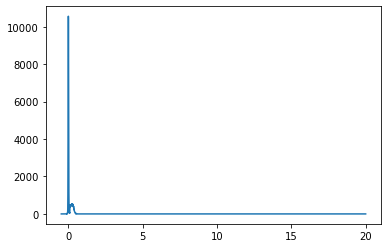

In [102]:
plt.plot(energy, counts)

# Device API, low level commands

In [14]:
#path_to_dll = r'C:\Users\sergeyg\WORK.FILES\Bruker Nano APIs\Device API\Sample\Bruker.API.Devices64.dll'
path_to_dll_Bruker = r'C:\Users\sergeyg\Github\Bruker Nano APIs\Device API\Sample\Bruker.API.Devices64.dll'


errors = {-1 : 'ERROR_UNSPECIFIED',
         -2 : 'ERROR_WRONG_PARAMETER',
         -3 : 'ERROR_DEVICE_NOT_INITIALIZED',
         -4 : 'ERROR_DSP_ERROR',
         -5 : 'ERROR_BUFFER_TOO_SMALL',
         -6 : 'ERROR_SCAN_ACTIVE',
         -7 : 'ERROR_INVALID_MEMORYBLOCK',
         -8 : 'ERROR_BUFFER_OVERFLOW',
         -9 : 'ERROR_LOG_NOT_AVAILABLE',
         -10 : 'ERROR_FILE_NOT_EXISTS'
}


bruker = ctypes.cdll.LoadLibrary(path_to_dll_Bruker)
print(path_to_dll_Bruker, bruker)



output = bruker.InitializeIOScan()  # establishes connection between IOScan device and user program.
if output == 0:
    # no error
    print('Connection to Bruker API established')
else:
    print('Connection failed')

C:\Users\sergeyg\Github\Bruker Nano APIs\Device API\Sample\Bruker.API.Devices64.dll <CDLL 'C:\Users\sergeyg\Github\Bruker Nano APIs\Device API\Sample\Bruker.API.Devices64.dll', handle aa0000 at 0x159e8d30580>
Connection to Bruker API established


In [15]:
point = bruker.ImageGetPoint()

print(point)

-100


In [16]:
external = True

output = bruker.ImageSetSEMExternMode(external)

if output == 0:
    # no error
    print(output, '; setting external SEM mode to ', str(external))
else:
    error_message = f'Could not set the external scan mode to {external}, ERROR code is {output}, {errors[output]}'
    print(error_message + '\n')

0 ; setting external SEM mode to  True


In [17]:
output = bruker.ImageGetAcquisitionMode()

if output==0:
    print(f'acquisition mode = {output}, normal image scan')
elif output==1:
    print(f'acquisition mode = {output}, SetPoint mode')    
if output==2:
    print(f'acquisition mode = {output}, external triggered mode (TTL input)')    

acquisition mode = 0, normal image scan


In [18]:
def create_point_array(coordinates):
    N = len(coordinates)  # number of points
    array_of_N_points = TPoint * N  # make a new "class" of array with N elements
    points = array_of_N_points()  # initialise an array variable
    #
    for ii, point in enumerate(points):
        x = coordinates[ii][0]
        y = coordinates[ii][1]
        points[ii].X = x
        points[ii].Y = y
    return points


coordinates = [[1, 2], [3, 4], [5, 6], [7, 8]]
N = len(coordinates)

points = create_point_array(coordinates)

output = bruker.ImageSetPointList(N, points)

print(points[0].X, points[0].Y)

1 2


In [19]:
# ImageSetConfiguration(256,256,1,1,12,
#                       true,false,false,false,
#                       0,0,0,0,
#                       cmw,pt);
#
#
#
# ImageWidth,   Number of pixels in horizontal direction
# ImageHeight,  Number of pixels in vertical direction
# PixelAverage, Number of pixel average cycles
# LineAverage,  Number of line average cycles
# SEBitcount: word;   Use input channel 1 for scan

# Input1Used,         Use input channel 2 for scan
# Input2Used,         Use power synchronization for scan
# PowerSyncUsed,      Use counters for scan
# CounterUsed: boolean;

# CounterIndex       Index of counter mode according to counter mode strings
# ActiveCounters: word;    Used counters for scanning, every bit set signals an active counter
# TiltAngle: integer;     Current sample tilt
# TiltDirection: byte;  Current tilt direction 0 = no tilt; 1 = tilt in X direction; 2 = tilt in Y direction
# return var CounterModeWord: word; Return value to set the counter mode
# return var PixelTime: word): integer; Return value for the pixel time according to the number of input channels used


# var CounterModeWord      //According to counter index the counter mode word for the PCI-Card
#                         : word;
# var PixelTime : word    //Current pixel time according to number of used input channels
#                         //normally 1µs for one channel, 2µs for two channels used



# TODO, the function seems to RETURN the pixel_time rather than to set it... 


image_width  = ctypes.c_int16(1024)
image_height = ctypes.c_int16(682)
pixel_average = ctypes.c_int16(1)
line_average  = ctypes.c_int16(1)
bit_depth = ctypes.c_int16(12) 
###
input_1_used    = ctypes.c_bool(True)
input_2_used    = ctypes.c_bool(False)
power_sync_used = ctypes.c_bool(False)
counter_used    = ctypes.c_bool(False)
###
counter_index = ctypes.c_int16(0)
active_counters = ctypes.c_int16(0)
tilt_angle = ctypes.c_int32(0)
tilt_direction = ctypes.c_int8(0)
###
counter_mode = ctypes.c_int16(0)
pixel_time = ctypes.c_int16(10)

bruker.ImageSetConfiguration(image_width, image_height,
                             pixel_average, line_average,
                             bit_depth, 
                             input_1_used, input_2_used,
                             power_sync_used, counter_used,
                             counter_index, active_counters,
                             tilt_angle, tilt_direction,
                             counter_mode, 
                             pixel_time)

-100

In [20]:
bruker.ImageStart()

0

In [21]:
bruker.ImageGetState()

-100